In [36]:
import pandas as pd 
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

In [37]:
feature_engineered_df = pd.read_csv('../data/feature-engineered/recession_probability.csv')

In [38]:
dtypes_dict = feature_engineered_df.dtypes.apply(lambda x: x.name).to_dict()
for col, dtype in dtypes_dict.items():
    print(f"{col}: {dtype}")


date: object
recession_probability: float64
1_month_recession_probability: float64
3_month_recession_probability: float64
6_month_recession_probability: float64
1_year_rate: float64
3_months_rate: float64
6_months_rate: float64
CPI: float64
INDPRO: float64
10_year_rate: float64
share_price: float64
unemployment_rate: float64
PPI: float64
OECD_CLI_index: float64
CSI_index: float64
Year: int64
Quarter_Number: int64
Month_Number: int64
gdp_per_capita: float64
seasonally_adjusted_INDPRO: float64
seasonally_adjusted_CPI: float64
seasonally_adjusted_unemployment_rate: float64
anomaly_INDPRO: int64
anomaly_CPI: int64
anomaly_unemployment_rate: int64
anomaly_PPI: int64
anomaly_share_price: int64
anomaly_1_year_rate: int64
anomaly_3_months_rate: int64
anomaly_6_months_rate: int64
anomaly_10_year_rate: int64
CPI_trend: float64
INDPRO_trend: float64
unemployment_rate_trend: float64
PPI_trend: float64
seasonally_adjusted_PPI: float64
1_year_rate_acf1_original: float64
1_year_rate_sumsq_acf_origina

In [39]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Financial indicators to forecast
financial_indicators = [
    '1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', 
    '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 
    'OECD_CLI_index', 'CSI_index', 'gdp_per_capita'
]

# Recession probability target columns to exclude from exog
recession_targets = [
    'recession_probability', '1_month_recession_probability', 
    '3_month_recession_probability', '6_month_recession_probability'
]

def prepare_data_split(df, date_col='date', split_year=2020):
    df[date_col] = pd.to_datetime(df[date_col])
    df_sorted = df.sort_values(date_col).reset_index(drop=True)
    train_data = df_sorted[df_sorted[date_col].dt.year < split_year].copy()
    test_data = df_sorted[df_sorted[date_col].dt.year >= split_year].copy()
    print(f"Training data: {len(train_data)} observations ({train_data[date_col].min()} to {train_data[date_col].max()})")
    print(f"Test data: {len(test_data)} observations ({test_data[date_col].min()} to {test_data[date_col].max()})")
    return train_data, test_data

def check_stationarity(series, series_name):
    result = adfuller(series.dropna())
    print(f'\n{series_name} Stationarity Test:')
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    if result[1] <= 0.05:
        print("Series is stationary")
        return True
    else:
        print("Series is non-stationary")
        return False

def auto_arima_with_exog(series, exog, max_p=3, max_d=2, max_q=3):
    best_aic = float('inf')
    best_order = None
    best_model = None

    # Clean exog
    exog = exog.fillna(method='ffill').fillna(method='bfill')
    exog = exog.replace([np.inf, -np.inf], np.nan)
    exog = exog.fillna(method='ffill').fillna(method='bfill')
    exog = exog.loc[:, exog.nunique() > 1]  # Remove constant columns
    
    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                try:
                    print(f"Trying ARIMA order: ({p},{d},{q})")
                    model = ARIMA(series, order=(p, d, q), exog=exog, trend='n')  # No constant trend
                    fitted_model = model.fit()
                    print(f"  Success: AIC = {fitted_model.aic}")
                    if fitted_model.aic < best_aic:
                        best_aic = fitted_model.aic
                        best_order = (p, d, q)
                        best_model = fitted_model
                except Exception as e:
                    print(f"  Failed ARIMA order ({p},{d},{q}): {e}")
                    continue

    return best_model, best_order, best_aic


def forecast_indicator_with_exog(train_df, test_df, indicator_name, forecast_steps=None):
    print(f"\n{'='*50}")
    print(f"Forecasting: {indicator_name}")
    print(f"{'='*50}")

    train_series = train_df[indicator_name].dropna()
    test_series = test_df[indicator_name].dropna()

    # Prepare exogenous variables: exclude target columns and the indicator itself
    features_to_exclude = recession_targets + financial_indicators
    train_exog = train_df.drop(columns=features_to_exclude, errors='ignore')
    test_exog = test_df.drop(columns=features_to_exclude, errors='ignore')

    # Align exog and endog indices
    train_exog = train_exog.loc[train_series.index]
    test_exog = test_exog.loc[test_series.index]

    # Clean exog
    train_exog = train_exog.fillna(method='ffill').fillna(method='bfill')
    train_exog = train_exog.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(method='bfill')
    train_exog = train_exog.loc[:, train_exog.nunique() > 1]  # Remove constant columns

    test_exog = test_exog.fillna(method='ffill').fillna(method='bfill')
    test_exog = test_exog.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(method='bfill')

    # Ensure test_exog columns are exactly the same as train_exog columns, in the same order
    test_exog = test_exog[train_exog.columns]

    # Now set forecast_steps properly
    if forecast_steps is None:
        forecast_steps = min(len(test_series), len(test_exog))

    # Stationarity test
    check_stationarity(train_series, indicator_name)

    # Fit ARIMA
    try:
        model, order, aic = auto_arima_with_exog(train_series, train_exog)
        print(f"Best ARIMA order: {order}")
        print(f"AIC: {aic:.2f}")

        forecast_result = model.forecast(steps=forecast_steps, exog=test_exog.iloc[:forecast_steps])
        forecast_ci = model.get_forecast(steps=forecast_steps, exog=test_exog.iloc[:forecast_steps]).conf_int()

        results = {
            'model': model,
            'order': order,
            'aic': aic,
            'forecast': forecast_result,
            'forecast_lower': forecast_ci.iloc[:, 0],
            'forecast_upper': forecast_ci.iloc[:, 1],
            'actual': test_series.iloc[:forecast_steps]
        }

        actual_values = test_series.iloc[:forecast_steps]
        mae = np.mean(np.abs(forecast_result - actual_values))
        rmse = np.sqrt(np.mean((forecast_result - actual_values) ** 2))
        mape = np.mean(np.abs((actual_values - forecast_result) / actual_values)) * 100

        print(f"MAE: {mae:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAPE: {mape:.2f}%")

        results.update({'mae': mae, 'rmse': rmse, 'mape': mape})

        return results

    except Exception as e:
        print(f"Error fitting ARIMA for {indicator_name}: {str(e)}")
        return None



def plot_forecast_results(results, indicator_name, train_series, test_dates):
    if results is None:
        return
    
    plt.figure(figsize=(12, 6))
    train_plot = train_series.tail(24)
    plt.plot(train_plot.index, train_plot.values, label='Training Data', color='blue')
    
    actual = results['actual']
    forecast_dates = test_dates[:len(actual)]
    plt.plot(forecast_dates, actual.values, label='Actual', color='green', linewidth=2)
    
    forecast = results['forecast']
    forecast_dates_full = test_dates[:len(forecast)]
    plt.plot(forecast_dates_full, forecast, label='Forecast', color='red', linewidth=2)
    
    plt.fill_between(forecast_dates_full, 
                     results['forecast_lower'], 
                     results['forecast_upper'], 
                     alpha=0.3, color='red', label='95% Confidence Interval')
    
    plt.title(f'{indicator_name} - ARIMA Forecast with Exogenous Variables')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def run_time_series_forecasting(df, financial_indicators, plot_results=True):
    train_data, test_data = prepare_data_split(df)
    
    all_results = {}
    forecasted_values = pd.DataFrame()
    forecasted_values['date'] = test_data['date'].reset_index(drop=True)
    
    for indicator in financial_indicators:
        if indicator not in df.columns:
            print(f"Warning: {indicator} not found in dataframe")
            continue
        
        results = forecast_indicator_with_exog(train_data.set_index('date'), test_data.set_index('date'), indicator)
        
        if results is not None:
            all_results[indicator] = results
            
            forecasted_values[f'{indicator}_forecast'] = results['forecast'].values
            forecasted_values[f'{indicator}_lower'] = results['forecast_lower'].values
            forecasted_values[f'{indicator}_upper'] = results['forecast_upper'].values
            
            if plot_results:
                plot_forecast_results(results, indicator, train_data.set_index('date')[indicator], test_data['date'])
    
    return all_results, forecasted_values, train_data, test_data


Training data: 635 observations (1967-02-01 00:00:00 to 2019-12-01 00:00:00)
Test data: 65 observations (2020-01-01 00:00:00 to 2025-05-01 00:00:00)

Forecasting: 1_year_rate

1_year_rate Stationarity Test:
ADF Statistic: -1.464638
p-value: 0.550926
Series is non-stationary
Trying ARIMA order: (0,0,0)
  Success: AIC = 2292.543875660671
Trying ARIMA order: (0,0,1)
  Success: AIC = 1990.4031426327538
Trying ARIMA order: (0,0,2)
  Success: AIC = 1855.279028383532
Trying ARIMA order: (0,0,3)
  Success: AIC = 1616.78123171142
Trying ARIMA order: (0,1,0)
  Success: AIC = 472.2703309917367
Trying ARIMA order: (0,1,1)
  Success: AIC = 425.1305584501736
Trying ARIMA order: (0,1,2)
  Success: AIC = 425.9681365825919
Trying ARIMA order: (0,1,3)
  Success: AIC = 426.47565524788536
Trying ARIMA order: (0,2,0)
  Success: AIC = 655.421226955797
Trying ARIMA order: (0,2,1)
  Success: AIC = 546.3196737639573
Trying ARIMA order: (0,2,2)
  Success: AIC = 498.27151398726016
Trying ARIMA order: (0,2,3)
  S

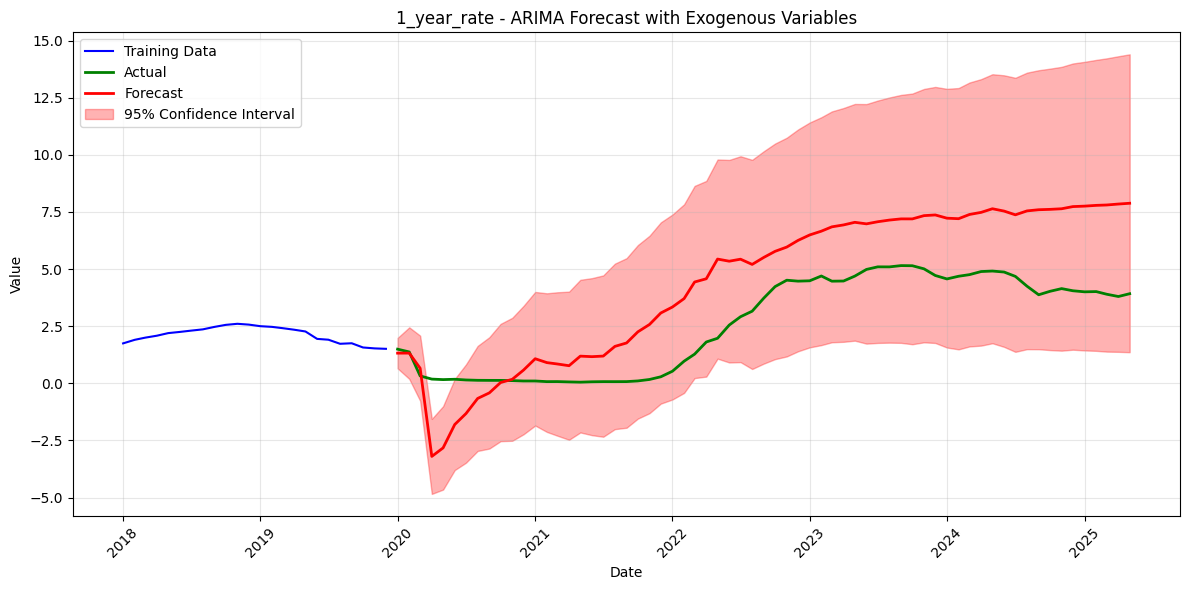


Forecasting: 3_months_rate

3_months_rate Stationarity Test:
ADF Statistic: -1.869398
p-value: 0.346591
Series is non-stationary
Trying ARIMA order: (0,0,0)
  Success: AIC = 2731.7013700753905
Trying ARIMA order: (0,0,1)
  Success: AIC = 2389.3332244955272
Trying ARIMA order: (0,0,2)
  Success: AIC = 2239.84511464559
Trying ARIMA order: (0,0,3)
  Success: AIC = 1948.656567160294
Trying ARIMA order: (0,1,0)
  Success: AIC = 684.0779109298619
Trying ARIMA order: (0,1,1)
  Success: AIC = 633.756199200019
Trying ARIMA order: (0,1,2)
  Success: AIC = 634.9286961660464
Trying ARIMA order: (0,1,3)
  Success: AIC = 636.5363321373596
Trying ARIMA order: (0,2,0)
  Success: AIC = 909.4937446242441
Trying ARIMA order: (0,2,1)
  Success: AIC = 714.227470316467
Trying ARIMA order: (0,2,2)
  Success: AIC = 660.2393831229114
Trying ARIMA order: (0,2,3)
  Success: AIC = 671.3264430207661
Trying ARIMA order: (1,0,0)
  Success: AIC = 1170.613404951915
Trying ARIMA order: (1,0,1)
  Success: AIC = 1186.35

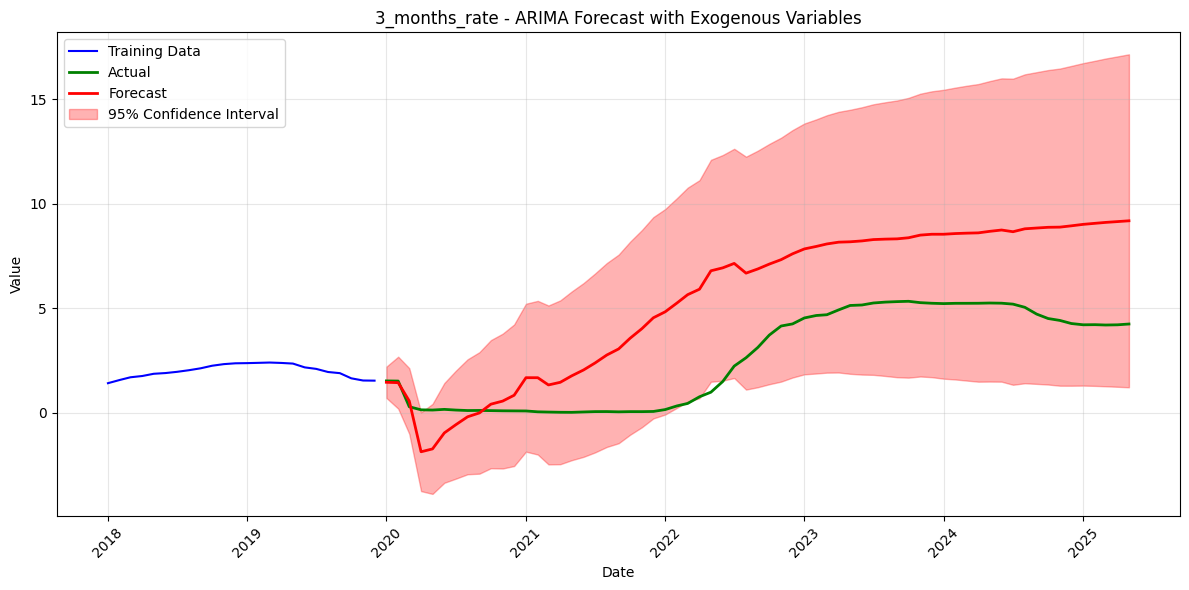


Forecasting: 6_months_rate

6_months_rate Stationarity Test:
ADF Statistic: -1.740531
p-value: 0.410360
Series is non-stationary
Trying ARIMA order: (0,0,0)
  Success: AIC = 2716.1185829077235
Trying ARIMA order: (0,0,1)
  Success: AIC = 2357.114692422076
Trying ARIMA order: (0,0,2)
  Success: AIC = 2206.2422559593124
Trying ARIMA order: (0,0,3)
  Success: AIC = 1925.30664845401
Trying ARIMA order: (0,1,0)
  Success: AIC = 593.7312626987632
Trying ARIMA order: (0,1,1)
  Success: AIC = 545.0400452964069
Trying ARIMA order: (0,1,2)
  Success: AIC = 547.0898053437345
Trying ARIMA order: (0,1,3)
  Success: AIC = 547.312807051421
Trying ARIMA order: (0,2,0)
  Success: AIC = 812.2433100808082
Trying ARIMA order: (0,2,1)
  Success: AIC = 638.8712020914118
Trying ARIMA order: (0,2,2)
  Success: AIC = 588.8545720138542
Trying ARIMA order: (0,2,3)
  Success: AIC = 594.6880486193351
Trying ARIMA order: (1,0,0)
  Success: AIC = 1105.2569896338862
Trying ARIMA order: (1,0,1)
  Success: AIC = 1107.

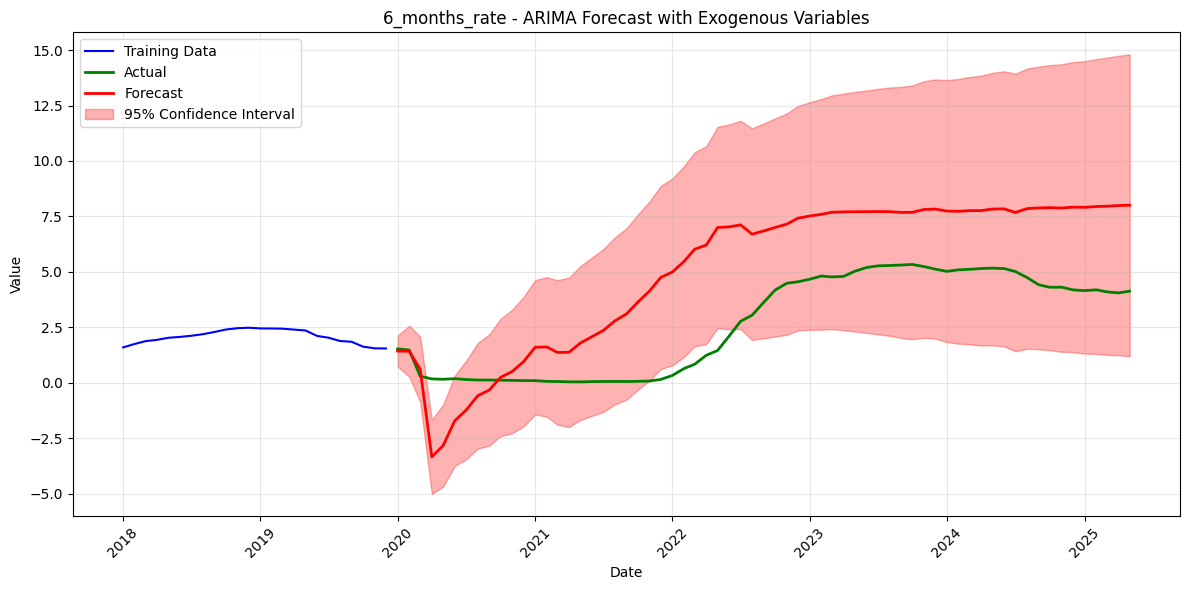


Forecasting: CPI

CPI Stationarity Test:
ADF Statistic: 0.230335
p-value: 0.973913
Series is non-stationary
Trying ARIMA order: (0,0,0)
  Success: AIC = 3194.134286343262
Trying ARIMA order: (0,0,1)
  Success: AIC = -294.7071239268764
Trying ARIMA order: (0,0,2)
  Success: AIC = -293.2849267576663
Trying ARIMA order: (0,0,3)
  Success: AIC = -286.24461937346007
Trying ARIMA order: (0,1,0)
  Success: AIC = -95.73787846955338
Trying ARIMA order: (0,1,1)
  Success: AIC = -204.4419507212453
Trying ARIMA order: (0,1,2)
  Success: AIC = -248.36249715700728
Trying ARIMA order: (0,1,3)
  Success: AIC = -263.5103240561755
Trying ARIMA order: (0,2,0)
  Success: AIC = 353.900802514526
Trying ARIMA order: (0,2,1)
  Success: AIC = -75.21396588300723
Trying ARIMA order: (0,2,2)
  Success: AIC = -75.60170529147226
Trying ARIMA order: (0,2,3)
  Success: AIC = -98.00287656554568
Trying ARIMA order: (1,0,0)
  Success: AIC = -292.288220972829
Trying ARIMA order: (1,0,1)
  Success: AIC = -292.81959600250

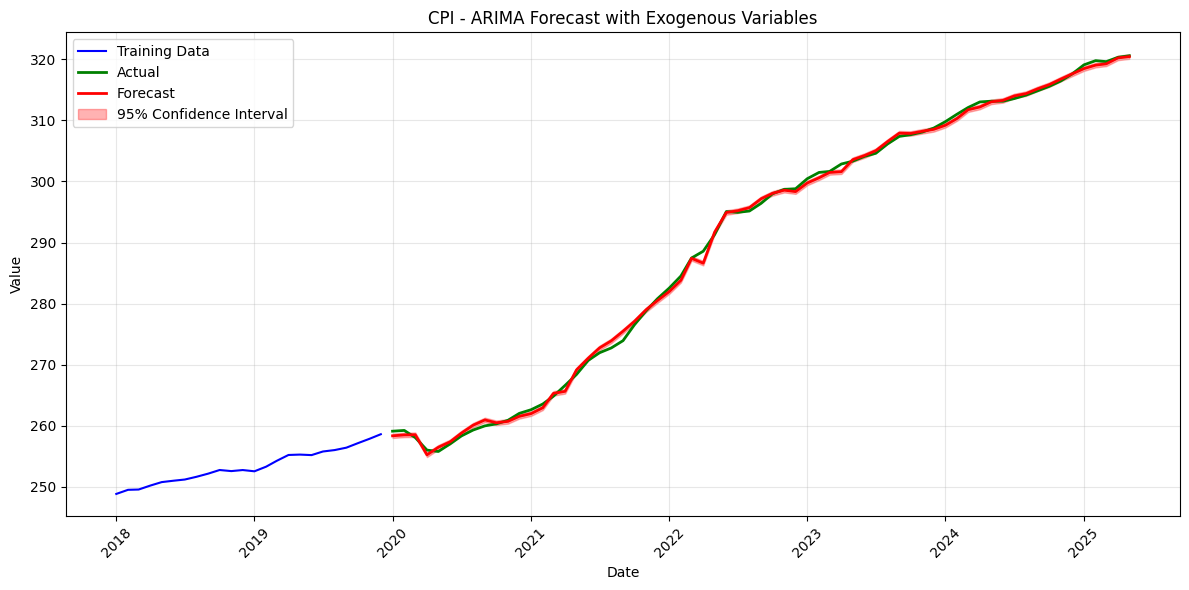


Forecasting: INDPRO

INDPRO Stationarity Test:
ADF Statistic: -0.970779
p-value: 0.763772
Series is non-stationary
Trying ARIMA order: (0,0,0)
  Success: AIC = 3310.9147210417495
Trying ARIMA order: (0,0,1)
  Success: AIC = -216.01374336959356
Trying ARIMA order: (0,0,2)
  Success: AIC = -226.8189732625031
Trying ARIMA order: (0,0,3)
  Success: AIC = -188.08848559723015
Trying ARIMA order: (0,1,0)
  Success: AIC = -56.46070537284925
Trying ARIMA order: (0,1,1)
  Success: AIC = -122.24820542802885
Trying ARIMA order: (0,1,2)
  Success: AIC = -163.12363309071668
Trying ARIMA order: (0,1,3)
  Success: AIC = -190.4062975725701
Trying ARIMA order: (0,2,0)
  Success: AIC = 519.7552429197098
Trying ARIMA order: (0,2,1)
  Success: AIC = -12.788031622771456
Trying ARIMA order: (0,2,2)
  Success: AIC = -31.57091918440848
Trying ARIMA order: (0,2,3)
  Success: AIC = -42.0310066839495
Trying ARIMA order: (1,0,0)
  Success: AIC = -231.35104500431498
Trying ARIMA order: (1,0,1)
  Success: AIC = -22

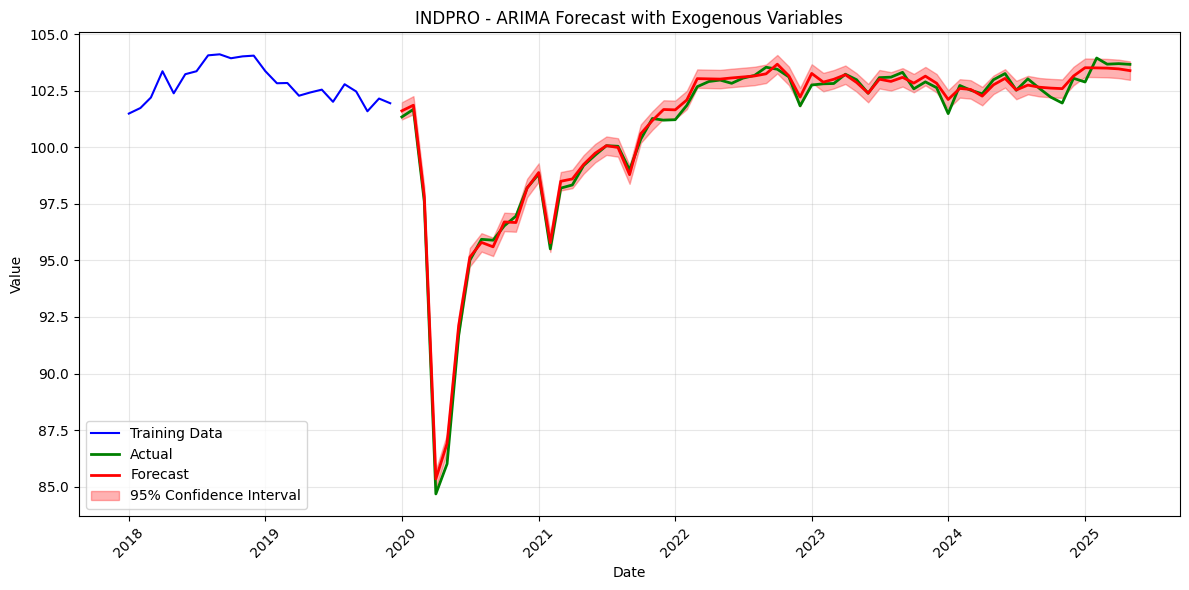


Forecasting: 10_year_rate

10_year_rate Stationarity Test:
ADF Statistic: -0.897583
p-value: 0.788767
Series is non-stationary
Trying ARIMA order: (0,0,0)
  Success: AIC = 2432.9183608150747
Trying ARIMA order: (0,0,1)
  Success: AIC = 2045.9738534392513
Trying ARIMA order: (0,0,2)
  Success: AIC = 1907.538190822434
Trying ARIMA order: (0,0,3)
  Success: AIC = 1510.144370904151
Trying ARIMA order: (0,1,0)
  Success: AIC = 208.2378242323296
Trying ARIMA order: (0,1,1)
  Success: AIC = 153.3377436380384
Trying ARIMA order: (0,1,2)
  Success: AIC = 147.16094481314028
Trying ARIMA order: (0,1,3)
  Success: AIC = 149.12171241041003
Trying ARIMA order: (0,2,0)
  Success: AIC = 453.94821771671513
Trying ARIMA order: (0,2,1)
  Success: AIC = 234.7366224556889
Trying ARIMA order: (0,2,2)
  Success: AIC = 190.97458624294364
Trying ARIMA order: (0,2,3)
  Success: AIC = 190.41321055897987
Trying ARIMA order: (1,0,0)
  Success: AIC = 732.2535886004348
Trying ARIMA order: (1,0,1)
  Success: AIC = 5

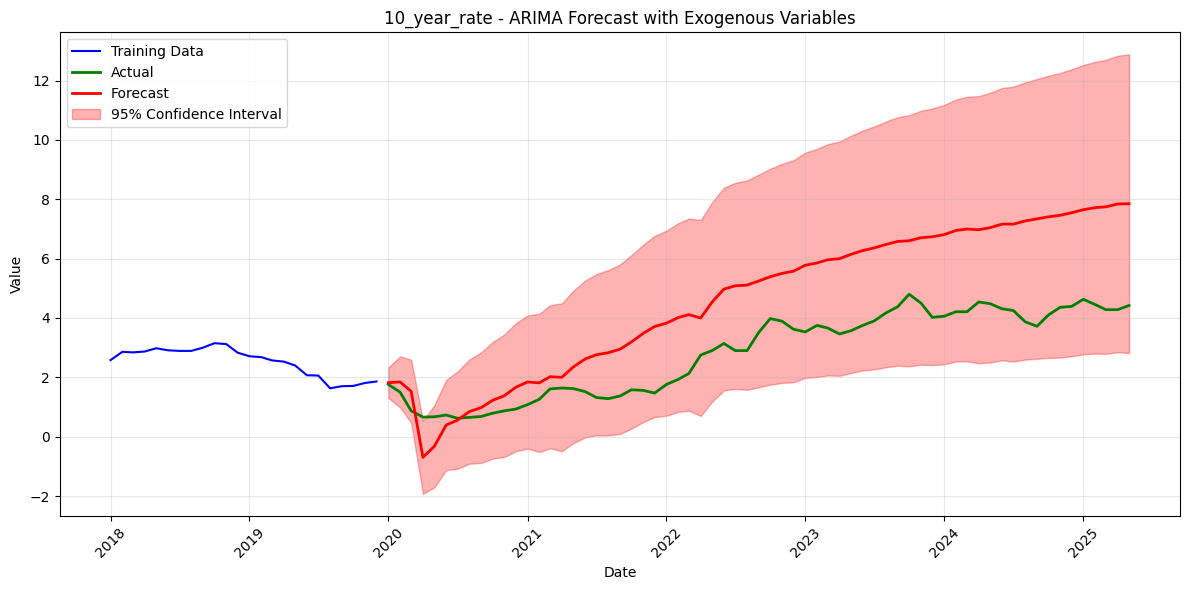


Forecasting: share_price

share_price Stationarity Test:
ADF Statistic: -0.059505
p-value: 0.953326
Series is non-stationary
Trying ARIMA order: (0,0,0)
  Success: AIC = 3113.4815104993436
Trying ARIMA order: (0,0,1)
  Success: AIC = -706.1660382116281
Trying ARIMA order: (0,0,2)
  Success: AIC = -899.3587250459453
Trying ARIMA order: (0,0,3)
  Success: AIC = -937.9144244614341
Trying ARIMA order: (0,1,0)
  Success: AIC = -1978.2416824912198
Trying ARIMA order: (0,1,1)
  Success: AIC = -2012.9532588095421
Trying ARIMA order: (0,1,2)
  Success: AIC = -2012.787343673106
Trying ARIMA order: (0,1,3)
  Success: AIC = -2010.7399973605725
Trying ARIMA order: (0,2,0)
  Success: AIC = -1709.3414552522604
Trying ARIMA order: (0,2,1)
  Success: AIC = -1894.5041217443968
Trying ARIMA order: (0,2,2)
  Success: AIC = -1929.435912707462
Trying ARIMA order: (0,2,3)
  Success: AIC = -1928.163340638686
Trying ARIMA order: (1,0,0)
  Success: AIC = -1652.3598032042426
Trying ARIMA order: (1,0,1)
  Succes

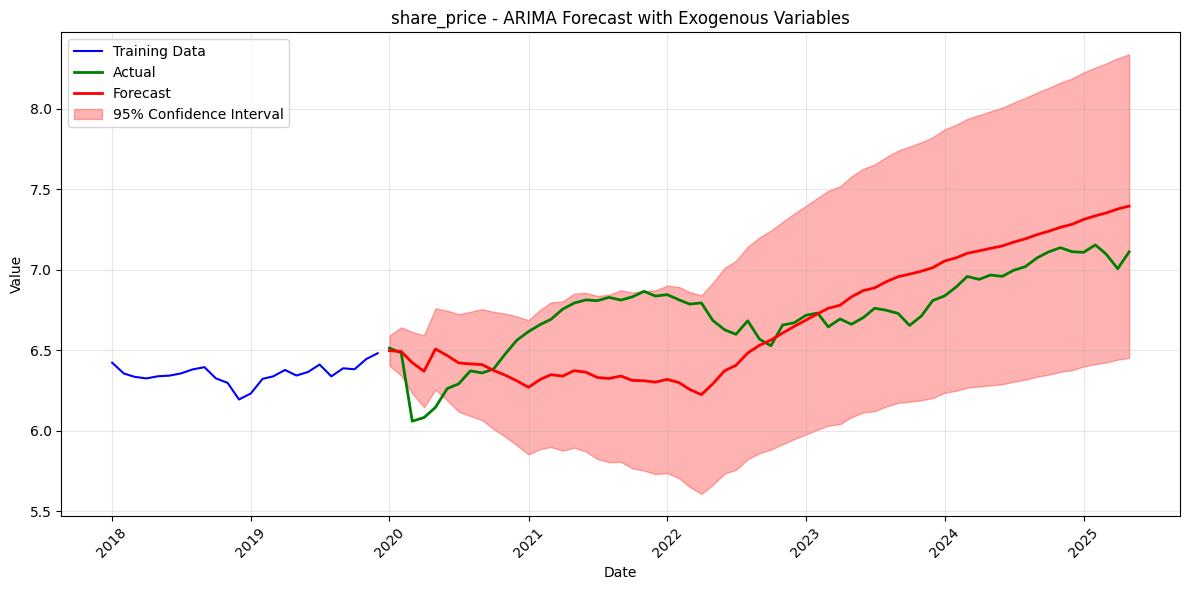


Forecasting: unemployment_rate

unemployment_rate Stationarity Test:
ADF Statistic: -3.046251
p-value: 0.030795
Series is stationary
Trying ARIMA order: (0,0,0)
  Success: AIC = 2050.4269608324153
Trying ARIMA order: (0,0,1)
  Success: AIC = -1481.8611383705404
Trying ARIMA order: (0,0,2)
  Success: AIC = -1488.735774402647
Trying ARIMA order: (0,0,3)
  Success: AIC = -1481.5517682262175
Trying ARIMA order: (0,1,0)
  Success: AIC = -1307.088600391545
Trying ARIMA order: (0,1,1)
  Success: AIC = -1384.1136464962528
Trying ARIMA order: (0,1,2)
  Success: AIC = -1410.182449086864
Trying ARIMA order: (0,1,3)
  Success: AIC = -1423.8896088882448
Trying ARIMA order: (0,2,0)
  Success: AIC = -726.0601460611231
Trying ARIMA order: (0,2,1)
  Success: AIC = -1257.7981228378428
Trying ARIMA order: (0,2,2)
  Success: AIC = -1302.5638541247686
Trying ARIMA order: (0,2,3)
  Success: AIC = -1300.6253417034864
Trying ARIMA order: (1,0,0)
  Success: AIC = -1489.0946302673974
Trying ARIMA order: (1,0,1

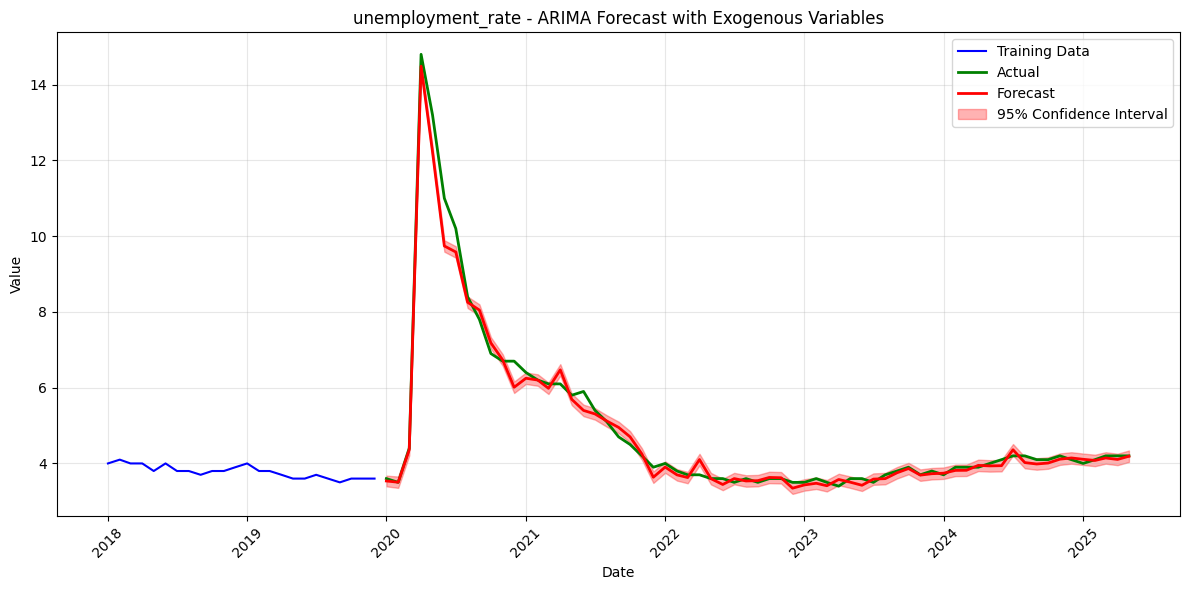


Forecasting: PPI

PPI Stationarity Test:
ADF Statistic: 0.191008
p-value: 0.971753
Series is non-stationary
Trying ARIMA order: (0,0,0)
  Success: AIC = 3209.6070922100407
Trying ARIMA order: (0,0,1)
  Success: AIC = 3012.6720077015843
Trying ARIMA order: (0,0,2)
  Success: AIC = 2928.635534289674
Trying ARIMA order: (0,0,3)
  Success: AIC = 2893.787466643913
Trying ARIMA order: (0,1,0)
  Success: AIC = 2891.1737517410415
Trying ARIMA order: (0,1,1)
  Success: AIC = 2866.4283625287744
Trying ARIMA order: (0,1,2)
  Success: AIC = 2831.655128910401
Trying ARIMA order: (0,1,3)
  Success: AIC = 2833.461585031452
Trying ARIMA order: (0,2,0)
  Success: AIC = 3022.5361372264388
Trying ARIMA order: (0,2,1)
  Success: AIC = 2938.5880445275952
Trying ARIMA order: (0,2,2)
  Success: AIC = 2896.7390307505384
Trying ARIMA order: (0,2,3)
  Success: AIC = 2841.942265226723
Trying ARIMA order: (1,0,0)
  Success: AIC = 2860.3997310492678
Trying ARIMA order: (1,0,1)
  Success: AIC = 2848.284892120001
T

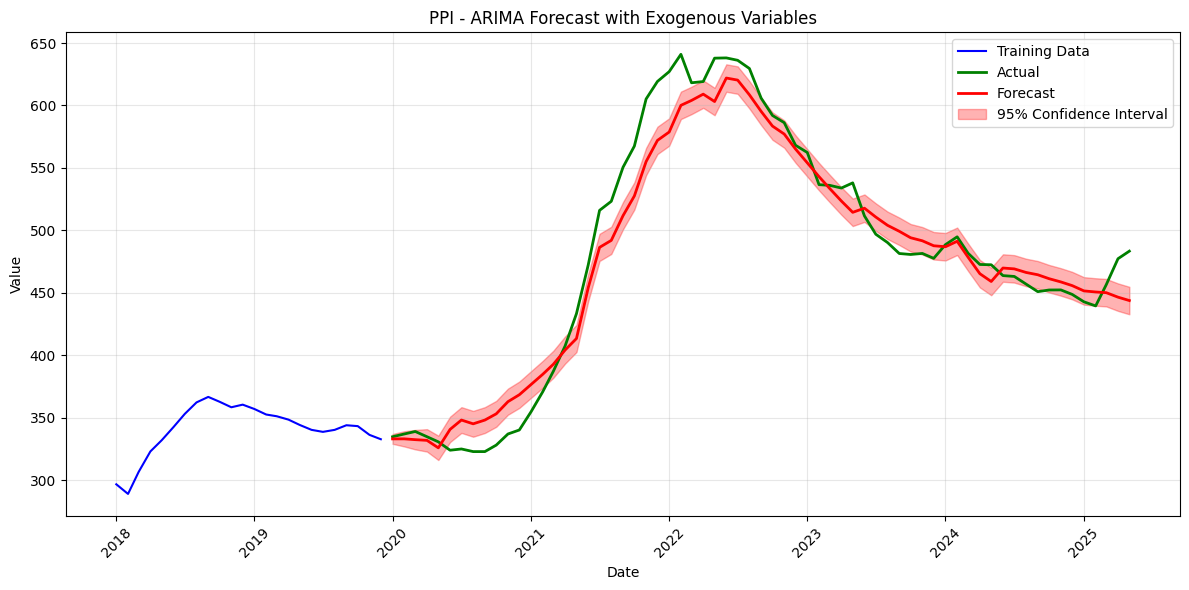


Forecasting: OECD_CLI_index

OECD_CLI_index Stationarity Test:
ADF Statistic: -6.053841
p-value: 0.000000
Series is stationary
Trying ARIMA order: (0,0,0)
  Success: AIC = 2074.7617431873605
Trying ARIMA order: (0,0,1)
  Success: AIC = 1667.6308969680294
Trying ARIMA order: (0,0,2)
  Success: AIC = 1594.4164517731772
Trying ARIMA order: (0,0,3)
  Success: AIC = 1263.9836743920519
Trying ARIMA order: (0,1,0)
  Success: AIC = -224.53672028798354
Trying ARIMA order: (0,1,1)
  Success: AIC = -930.1730375732277
Trying ARIMA order: (0,1,2)
  Success: AIC = -1330.7164902765862
Trying ARIMA order: (0,1,3)
  Success: AIC = -1171.9246506332493
Trying ARIMA order: (0,2,0)
  Success: AIC = -1700.0141116834993
Trying ARIMA order: (0,2,1)
  Success: AIC = -2437.3265851494198
Trying ARIMA order: (0,2,2)
  Success: AIC = -2938.935003189563
Trying ARIMA order: (0,2,3)
  Success: AIC = -3145.742474501584
Trying ARIMA order: (1,0,0)
  Success: AIC = 443.19817590980574
Trying ARIMA order: (1,0,1)
  Succe

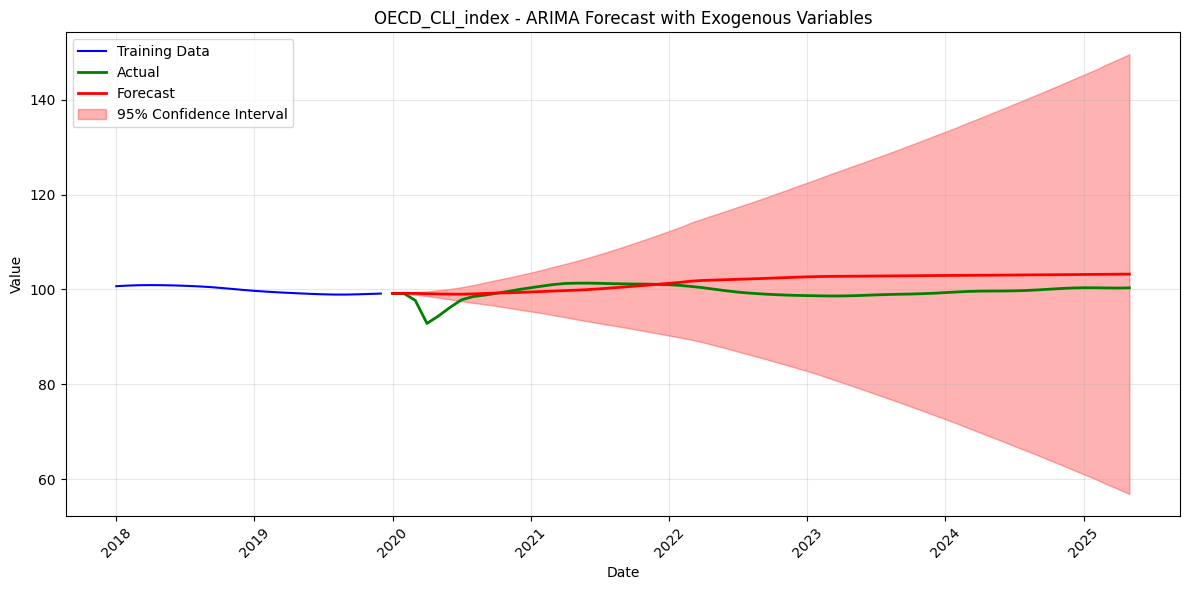


Forecasting: CSI_index

CSI_index Stationarity Test:
ADF Statistic: -3.389553
p-value: 0.011320
Series is stationary
Trying ARIMA order: (0,0,0)
  Success: AIC = 4523.0200502410535
Trying ARIMA order: (0,0,1)
  Success: AIC = 4102.48510536324
Trying ARIMA order: (0,0,2)
  Success: AIC = 3906.9332138896116
Trying ARIMA order: (0,0,3)
  Success: AIC = 3843.912374678099
Trying ARIMA order: (0,1,0)
  Success: AIC = 3483.6686859776382
Trying ARIMA order: (0,1,1)
  Success: AIC = 3483.5282680800838
Trying ARIMA order: (0,1,2)
  Success: AIC = 3472.4263258331007
Trying ARIMA order: (0,1,3)
  Success: AIC = 3470.6773824358006
Trying ARIMA order: (0,2,0)
  Success: AIC = 3934.1057405971387
Trying ARIMA order: (0,2,1)
  Success: AIC = 3488.225480041164
Trying ARIMA order: (0,2,2)
  Success: AIC = 3489.580463073177
Trying ARIMA order: (0,2,3)
  Success: AIC = 3478.5279161490503
Trying ARIMA order: (1,0,0)
  Success: AIC = 3648.9398947315667
Trying ARIMA order: (1,0,1)
  Success: AIC = 3646.13853

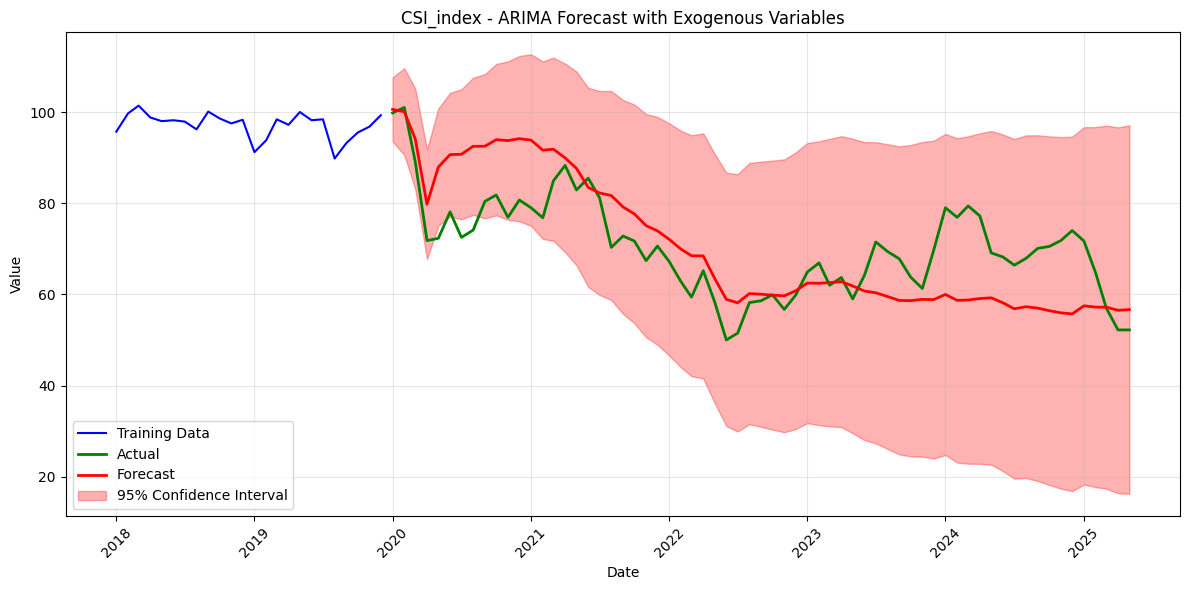


Forecasting: gdp_per_capita

gdp_per_capita Stationarity Test:
ADF Statistic: -0.060547
p-value: 0.953229
Series is non-stationary
Trying ARIMA order: (0,0,0)
  Success: AIC = 10034.366663006293
Trying ARIMA order: (0,0,1)
  Success: AIC = 9385.729459438977
Trying ARIMA order: (0,0,2)
  Success: AIC = 8961.361244640346
Trying ARIMA order: (0,0,3)
  Success: AIC = 8816.981005129659
Trying ARIMA order: (0,1,0)
  Success: AIC = 7412.733517568098
Trying ARIMA order: (0,1,1)
  Success: AIC = 7394.961168014672
Trying ARIMA order: (0,1,2)
  Success: AIC = 7388.129126080955
Trying ARIMA order: (0,1,3)
  Success: AIC = 7390.102815809859
Trying ARIMA order: (0,2,0)
  Success: AIC = 7131.071943592395
Trying ARIMA order: (0,2,1)
  Success: AIC = 7133.050061469247
Trying ARIMA order: (0,2,2)
  Success: AIC = 7134.081435850017
Trying ARIMA order: (0,2,3)
  Success: AIC = 6994.065238027688
Trying ARIMA order: (1,0,0)
  Success: AIC = 7552.663045092146
Trying ARIMA order: (1,0,1)
  Success: AIC = 783

ValueError: Length of values (64) does not match length of index (65)

In [40]:
all_results, forecasted_values, train_data, test_data = run_time_series_forecasting(feature_engineered_df, financial_indicators)
